# With TF

In [27]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

In [28]:
def show_image(image_list, label_list= None):
    """Plot images."""
    
    fig = plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_list):
        
        # if image is numpy array
        if isinstance(file, np.ndarray):
            img= file.astype(np.int32)
        # if image is PIL image
        else:
            img = np.array(file, dtype= np.int32)
        
        print('Image shape:', img.shape)
        ax = fig.add_subplot(2, int(len(image_list)/2), i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
    
        if label_list is not None:
            ax.set_title(label_list[i])
    
    plt.tight_layout()
    plt.show()

## Load Dataset

In [29]:
train_path= 'dataset/dogs-vs-cat/train'
valid_path= 'dataset/dogs-vs-cat/valid'
test_path= 'dataset/dogs-vs-cat/test'
batch_size= 8

train_ds= image_dataset_from_directory(
    train_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'binary',
)
val_ds= image_dataset_from_directory(
    valid_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'binary',
)
test_ds= image_dataset_from_directory(
    test_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'binary',
)

Found 402 files belonging to 2 classes.
Found 103 files belonging to 2 classes.
Found 251 files belonging to 2 classes.


Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


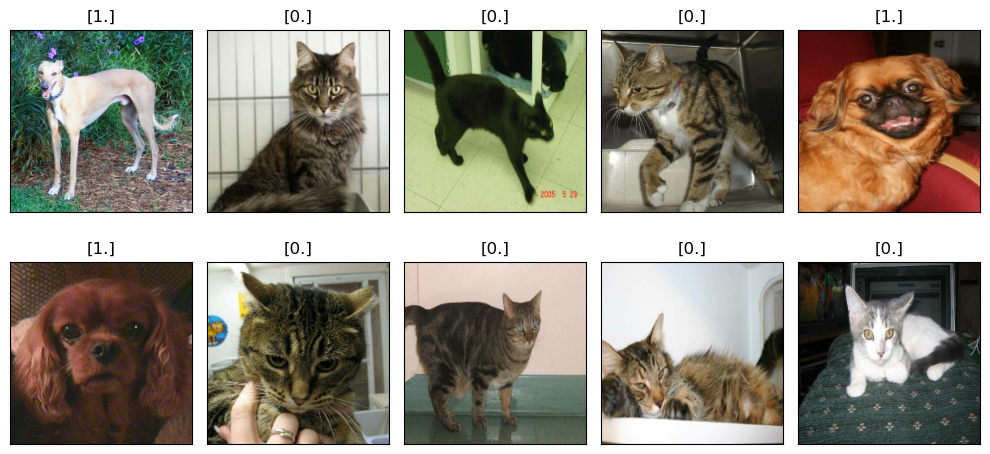

In [30]:
samples= train_ds.unbatch().take(10)
images= []
labels= []

for (image, label) in samples.as_numpy_iterator():
    images.append(image)
    labels.append(label)

show_image(images, labels)

## Create Model

In [31]:
base_model= vgg16.VGG16(include_top= False, 
                        weights= 'imagenet', 
                        input_shape= (224, 224, 3),
                        )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# freeze all layers
for layer in base_model.layers:
    layer.trainable= False

In [35]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
last_layer= base_model.get_layer(index= -1)
last_layer_output= last_layer.output
last_layer_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [9]:
# preprocessing
data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [10]:
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation

x = vgg16.preprocess_input(x) # apply input value scaling

x = base_model(x) # run through VGG16

x= Flatten()(x)

x= Dense(64, activation= 'relu', name= 'FC_2')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(32, activation= 'relu', name= 'FC_3')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(16, activation= 'relu', name= 'FC_4')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

outputs= Dense(1, activation= 'sigmoid', name= 'sigmoid')(x)

new_model= Model(inputs= inputs, outputs= outputs)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [11]:
new_model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="output/cat_dog_pretrained.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

epochs = 10
history = new_model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

Epoch 1/10


13/13 [==============================] - 63s 5s/step - loss: 0.5512 - accuracy: 0.7289 - val_loss: 0.2116 - val_accuracy: 0.9320
Epoch 2/10
13/13 [==============================] - 58s 5s/step - loss: 0.3141 - accuracy: 0.8831 - val_loss: 0.1479 - val_accuracy: 0.9417
Epoch 3/10
13/13 [==============================] - 60s 5s/step - loss: 0.2483 - accuracy: 0.9279 - val_loss: 0.1061 - val_accuracy: 0.9515
Epoch 4/10
13/13 [==============================] - 59s 5s/step - loss: 0.2092 - accuracy: 0.9303 - val_loss: 0.1186 - val_accuracy: 0.9417
Epoch 5/10
13/13 [==============================] - 63s 5s/step - loss: 0.2019 - accuracy: 0.9478 - val_loss: 0.1339 - val_accuracy: 0.9515
Epoch 6/10
13/13 [==============================] - 62s 5s/step - loss: 0.1439 - accuracy: 0.9602 - val_loss: 0.1060 - val_accuracy: 0.9612
Epoch 7/10
13/13 [==============================] - 68s 5s/step - loss: 0.1176 - accuracy: 0.9776 - val_loss: 0.1104 - val_accuracy: 0.9612
Epoch 8/10
13/13 [=============

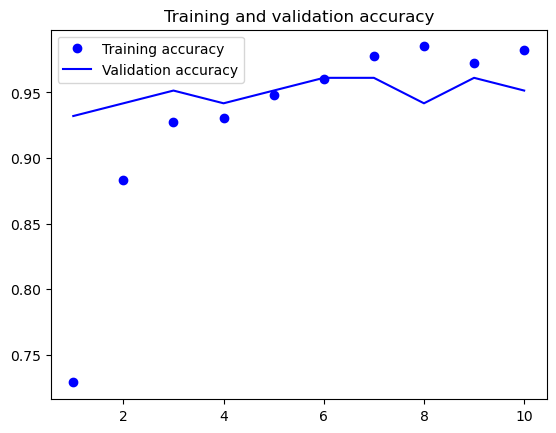

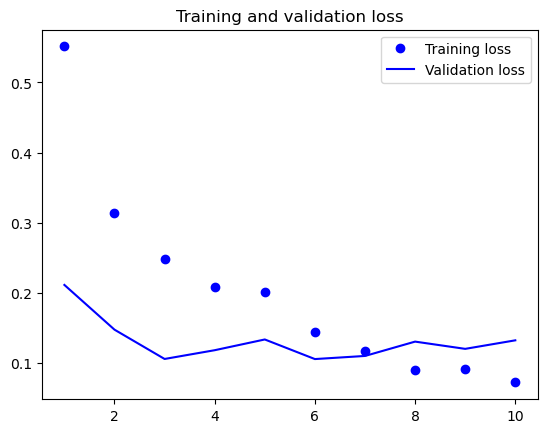

In [13]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_loss, test_acc= new_model.evaluate(test_ds)
print(f'Test accuracy = {test_acc: .4f} - test loss = {test_loss: 4f}')

8/8 [==============================] - 28s 3s/step - loss: 0.0664 - accuracy: 0.9920
Test accuracy =  0.9920 - test loss =  0.066354


Now we try again with finetuning the last 4 layers of convolutional layers.
1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we
added.

# With Pytorch

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F

from pathlib import Path
import os
from PIL import Image
import numpy as np

In [16]:
batch_size= 8

transforms_train= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_test= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_label= transforms.Compose([
    transforms.ToTensor(),
    lambda x: F.one_hot(x, -1)
])

# train
dir_= Path('dataset/dogs-vs-cat/train')
train_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_train, 
)
train_dl= DataLoader(
    train_set,
    batch_size= batch_size,
    shuffle= True
)

# validation
dir_= Path('dataset/dogs-vs-cat/valid')
val_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_train,
)
val_dl= DataLoader(
    val_set, 
    batch_size= 
    batch_size, 
    shuffle= True
)

# test
dir_= Path('dataset/dogs-vs-cat/test')
test_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_test,
)
test_dl= DataLoader(
    test_set, 
    batch_size= batch_size, 
    shuffle= False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

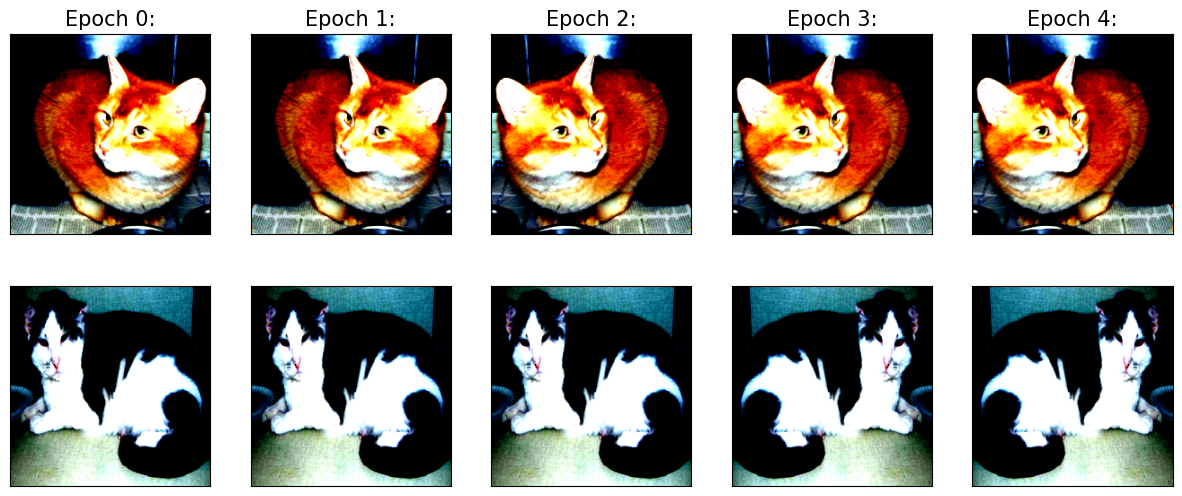

In [17]:
batch_size = 2
augment_samples= DataLoader(train_set, batch_size= batch_size)

fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(augment_samples))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

In [18]:
base_model= models.vgg16(weights='IMAGENET1K_V1')
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
base_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [20]:
base_model.classifier[-1].out_features

1000

In [21]:
base_model.classifier.add_module(
    name= 'binary_clf', 
    module= nn.Linear(
        in_features= base_model.classifier[-1].out_features, 
        out_features= 2)
)

In [22]:
base_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (binary_clf): Linear(in_features=1000, out_features=2, bias=True)
)

In [23]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(base_model.parameters(), lr= 0.0001)

n_epochs= 1
log_print= 1

n_train_samples= len(train_dl.dataset)
n_val_samples= len(val_dl.dataset)

In [24]:
acc_hist_train= [0] * n_epochs
acc_hist_val= [0] * n_epochs

loss_hist_train= [0] * n_epochs
loss_hist_val= [0] * n_epochs

for epoch in range(n_epochs):

    base_model.train()
    for x_batch, y_batch in train_dl:
        
        y_pred_logits= base_model(x_batch)
        # loss= loss_fn(y_pred_logits, y_pred)
        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()
        
        # y_pred= torch.argmax(y_pred_logits, dim= 1)
        # true_pred= (y_pred == y_batch)
        
        print(y_pred_logits, y_batch)
        break

tensor([[ 0.5269, -0.7478],
        [-1.0804, -4.1379],
        [-3.1270,  0.3960],
        [-2.9673,  0.3425],
        [-0.6527, -0.8188],
        [-2.8029,  1.0567],
        [-0.2311, -2.2373],
        [-0.5335, -0.1504]], grad_fn=<AddmmBackward0>) tensor([1, 1, 0, 0, 1, 0, 1, 0])


In [25]:
tensor = [
    [-1.4113, -0.0262],
    [0.3583, -1.4708],
    [-0.8076, -1.6834],
    [0.2654, -1.1023],
    [2.9400, 0.7721],
    [-0.2965, -0.9601],
    [1.5183, 0.9368],
    [-1.2978, -0.4997],
]
t = torch.Tensor(tensor)
label = torch.LongTensor([1, 0, 0, 1, 0, 1, 1, 1])
label.reshape(-1, 1)

tensor([[1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]])